In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.ensemble import RandomForestClassifier


In [14]:
data = pd.read_csv('data/cleaned_data.csv', parse_dates=['author_date_of_birth', 'publication_date'])

# Feature engineering

In [15]:
data['description_length'] = data['description'].str.len()

In [16]:
categorical_features = ['language', 'category', 'format']

In [17]:
data['language'].unique()

array(['polski', 'angielski'], dtype=object)

In [18]:
le = LabelEncoder()
for cat in categorical_features:
    data[cat] = le.fit_transform(data[cat])

In [19]:
rating_features = [f'rating_{i}' for i in range(1, 11)]

In [20]:
# to be predicted
threshold = 2000
data['bestseller'] = (data['number_of_people_has'] >= threshold).astype(int)

In [21]:
scaler = StandardScaler()

In [22]:
data.columns

Index(['author_average_rating', 'author_number_of_people_read',
       'author_number_of_people_wants_to_read', 'author_date_of_birth',
       'author_number_of_fans', 'author_number_of_books_written',
       'author_number_of_awards', 'number_of_user_opinions',
       'number_of_user_ratings', 'number_of_discussions',
       'number_of_people_read', 'publication_date', 'number_of_pages',
       'series', 'rating_1', 'rating_2', 'rating_3', 'rating_4', 'rating_5',
       'rating_6', 'rating_7', 'rating_8', 'rating_9', 'rating_10', 'category',
       'part_of_cycle', 'language', 'number_of_people_has',
       'number_of_people_favorite', 'number_of_people_wants_to_read',
       'number_of_people_wants_as_gift', 'number_of_people_currently_read',
       'description', 'format', 'description_length', 'bestseller'],
      dtype='object')

In [ ]:
data = data.drop(['number_of_user_opinions', 'number_of_user_opinions', 'number_of_user_ratings', 'number_of_discussions', 'number_of_people_read', 'number_of_people_has', 'number_of_people_favorite', 'number_of_people_currently_read', 'number_of_people_wants_to_read', 'number_of_people_wants_as_gift', 'number_of_people_currently_read', 'description', 'series', 'publication_date', 'author_date_of_birth'], axis=1)

KeyError: "['number_of_user_opinions', 'number_of_user_opinions', 'number_of_user_ratings', 'number_of_discussions', 'number_of_people_read', 'number_of_people_has', 'number_of_people_favorite', 'number_of_people_currently_read', 'number_of_people_wants_to_read', 'number_of_people_wants_as_gift', 'number_of_people_currently_read', 'description', 'series'] not found in axis"

In [34]:
data.columns

Index(['author_average_rating', 'author_number_of_people_read',
       'author_number_of_people_wants_to_read', 'author_date_of_birth',
       'author_number_of_fans', 'author_number_of_books_written',
       'author_number_of_awards', 'number_of_pages', 'rating_1', 'rating_2',
       'rating_3', 'rating_4', 'rating_5', 'rating_6', 'rating_7', 'rating_8',
       'rating_9', 'rating_10', 'category', 'part_of_cycle', 'language',
       'format', 'description_length', 'bestseller'],
      dtype='object')

In [35]:
correlation_matrix = data.corr()

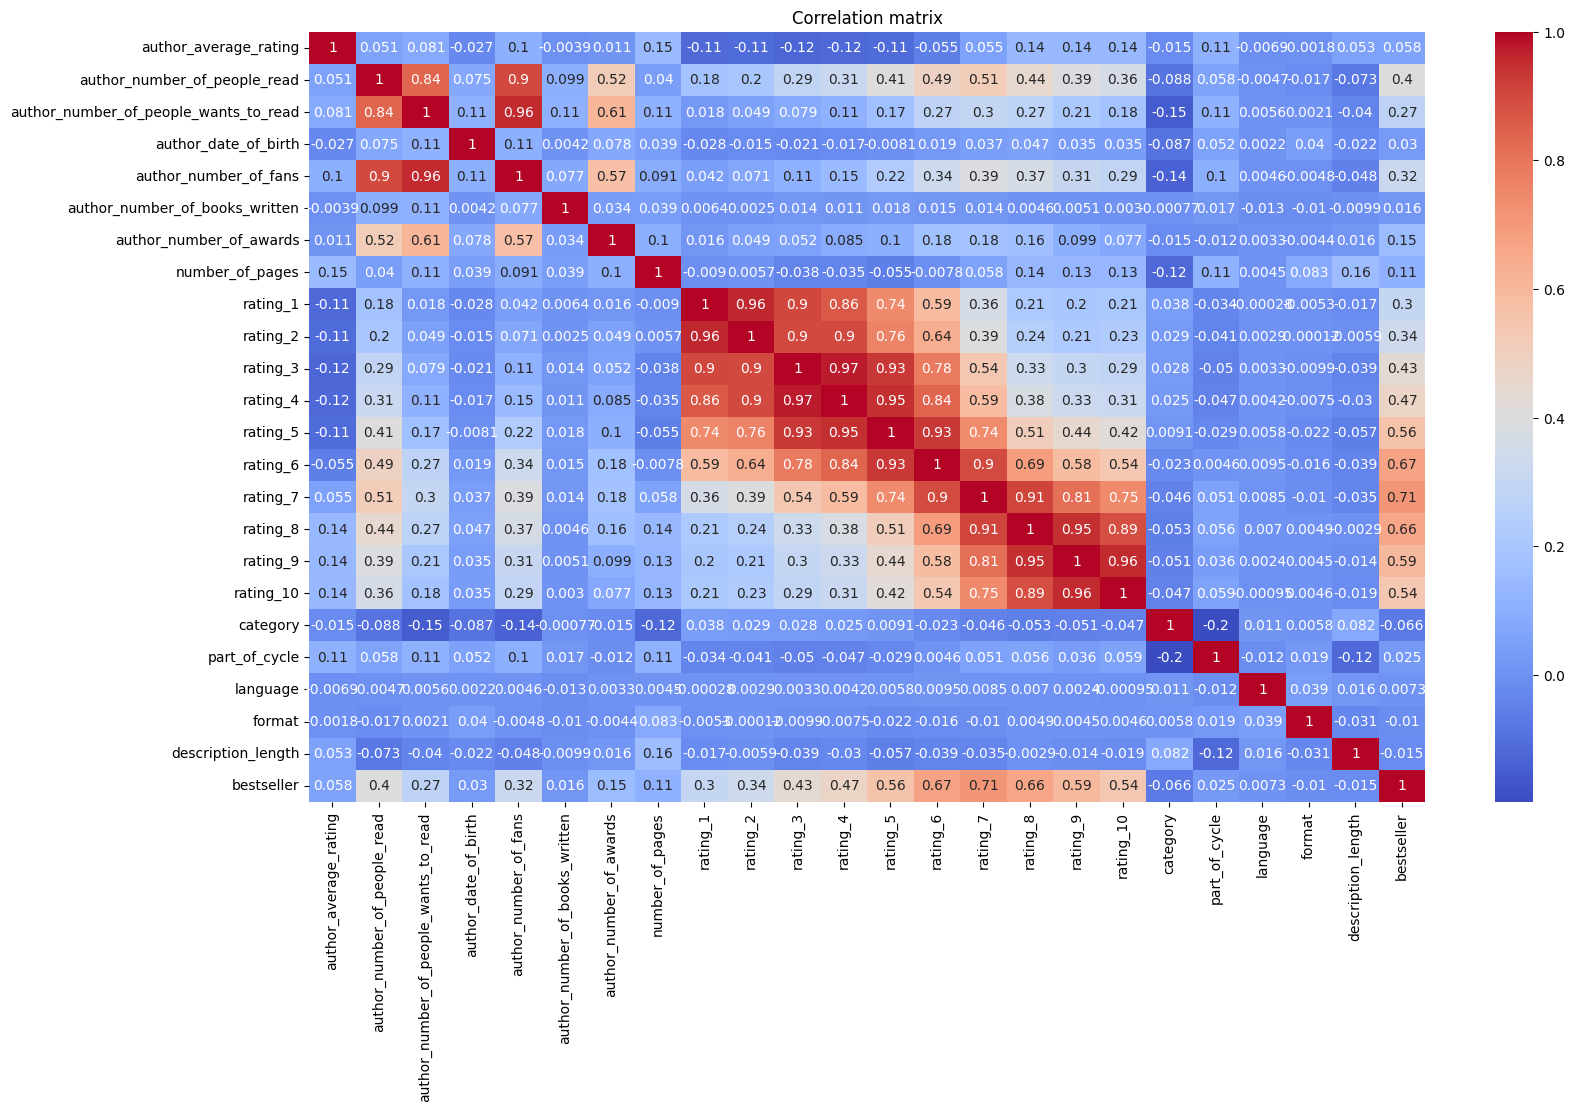

In [36]:
plt.figure(figsize=(18, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation matrix')
plt.show()

In [37]:
X = data.drop(['bestseller'], axis=1)
y = data['bestseller']

In [38]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=80085)
print('Train size:', X_train.shape)
print('Test size:', X_test.shape)

Train size: (7790, 23)
Test size: (1948, 23)


In [39]:
from sklearn.feature_selection import SelectKBest, f_classif, RFE

In [40]:
forest_classifier = RandomForestClassifier(n_estimators=100, random_state=1982556647665255855)

In [42]:
X_train.dtypes

author_average_rating                           float64
author_number_of_people_read                      int64
author_number_of_people_wants_to_read             int64
author_date_of_birth                     datetime64[ns]
author_number_of_fans                             int64
author_number_of_books_written                    int64
author_number_of_awards                           int64
number_of_pages                                 float64
rating_1                                          int64
rating_2                                          int64
rating_3                                          int64
rating_4                                          int64
rating_5                                          int64
rating_6                                          int64
rating_7                                          int64
rating_8                                          int64
rating_9                                          int64
rating_10                                       

In [41]:
rfe = RFE(forest_classifier, n_features_to_select=5)
rfe.fit(X_train, y_train)

DTypePromotionError: The DType <class 'numpy.dtypes.DateTime64DType'> could not be promoted by <class 'numpy.dtypes.Float64DType'>. This means that no common DType exists for the given inputs. For example they cannot be stored in a single array unless the dtype is `object`. The full list of DTypes is: (<class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Int64DType'>, <class 'numpy.dtypes.Int64DType'>, <class 'numpy.dtypes.DateTime64DType'>, <class 'numpy.dtypes.Int64DType'>, <class 'numpy.dtypes.Int64DType'>, <class 'numpy.dtypes.Int64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Int64DType'>, <class 'numpy.dtypes.Int64DType'>, <class 'numpy.dtypes.Int64DType'>, <class 'numpy.dtypes.Int64DType'>, <class 'numpy.dtypes.Int64DType'>, <class 'numpy.dtypes.Int64DType'>, <class 'numpy.dtypes.Int64DType'>, <class 'numpy.dtypes.Int64DType'>, <class 'numpy.dtypes.Int64DType'>, <class 'numpy.dtypes.Int64DType'>, <class 'numpy.dtypes.Int64DType'>, <class 'numpy.dtypes.Int64DType'>, <class 'numpy.dtypes.Int64DType'>, <class 'numpy.dtypes.Int64DType'>, <class 'numpy.dtypes.Int64DType'>)